  posted_date  job_postings_count
0      2023Q3                  30
1      2023Q4                 241
2      2024Q1                 262
3      2024Q2                 213
4      2024Q3                 269
5      2024Q4                 262
6      2025Q1                 267
7      2025Q2                 234
8      2025Q3                 222


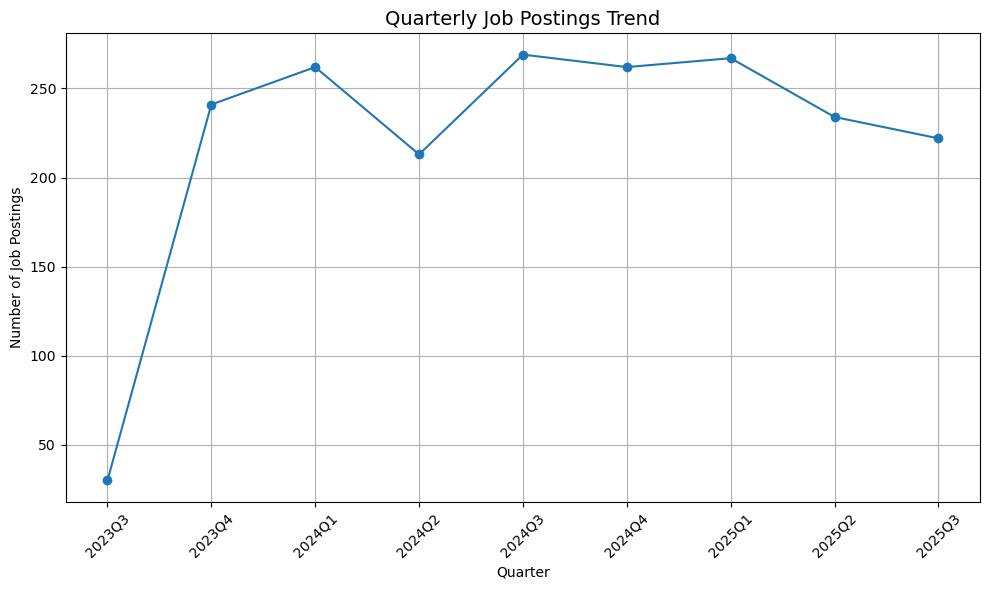

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "ai_job_market.xlsx"
data = pd.read_excel(file_path, sheet_name="ai_job_market (2)")

data['posted_date'] = pd.to_datetime(data['posted_date'], errors='coerce')

quarterly_counts = (
    data.groupby(data['posted_date'].dt.to_period('Q'))
    .size()
    .reset_index(name='job_postings_count')
)

quarterly_counts['posted_date'] = quarterly_counts['posted_date'].astype(str)

print(quarterly_counts)

plt.figure(figsize=(10, 6))
plt.plot(quarterly_counts['posted_date'], quarterly_counts['job_postings_count'], marker='o', linestyle='-')
plt.title("Quarterly Job Postings Trend", fontsize=14)
plt.xlabel("Quarter")
plt.ylabel("Number of Job Postings")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


[Job Title Trend]
job_title  AI Product Manager  AI Researcher  Computer Vision Engineer  \
period                                                                   
2023Q3                      6              3                         4   
2023Q4                     30             31                        34   
2024Q1                     32             30                        37   
2024Q2                     26             26                        21   
2024Q3                     41             31                        27   
2024Q4                     31             26                        22   
2025Q1                     34             32                        25   
2025Q2                     28             27                        37   
2025Q3                     30             31                        23   

job_title  Data Analyst  Data Scientist  ML Engineer  NLP Engineer  \
period                                                               
2023Q3                2   

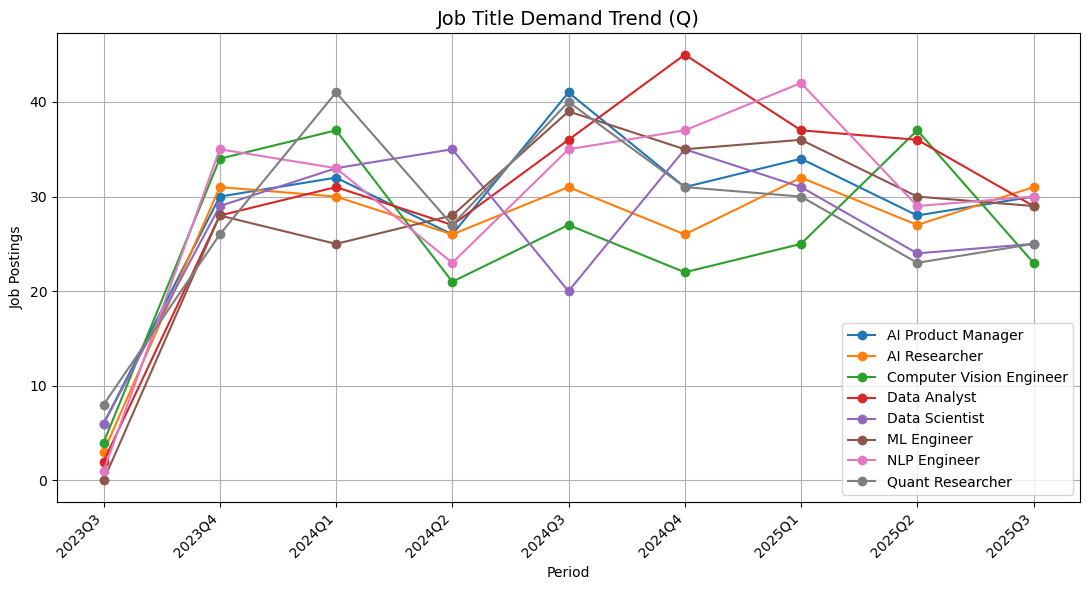


[Skill Trend]
skill   Azure  Excel  FastAPI  Hugging Face  NumPy  Pandas  \
period                                                       
2023Q3      5      6        8            11      7       3   
2023Q4     44     44       49            57     58      49   
2024Q1     59     74       52            48     55      68   
2024Q2     42     52       49            43     42      34   
2024Q3     62     46       51            63     51      60   
2024Q4     60     66       61            50     59      50   
2025Q1     61     46       57            48     54      54   
2025Q2     37     54       47            44     52      67   
2025Q3     43     44       45            44     38      42   

skill   Reinforcement Learning  TensorFlow  
period                                      
2023Q3                       5          10  
2023Q4                      46          56  
2024Q1                      59          62  
2024Q2                      43          49  
2024Q3                      60  

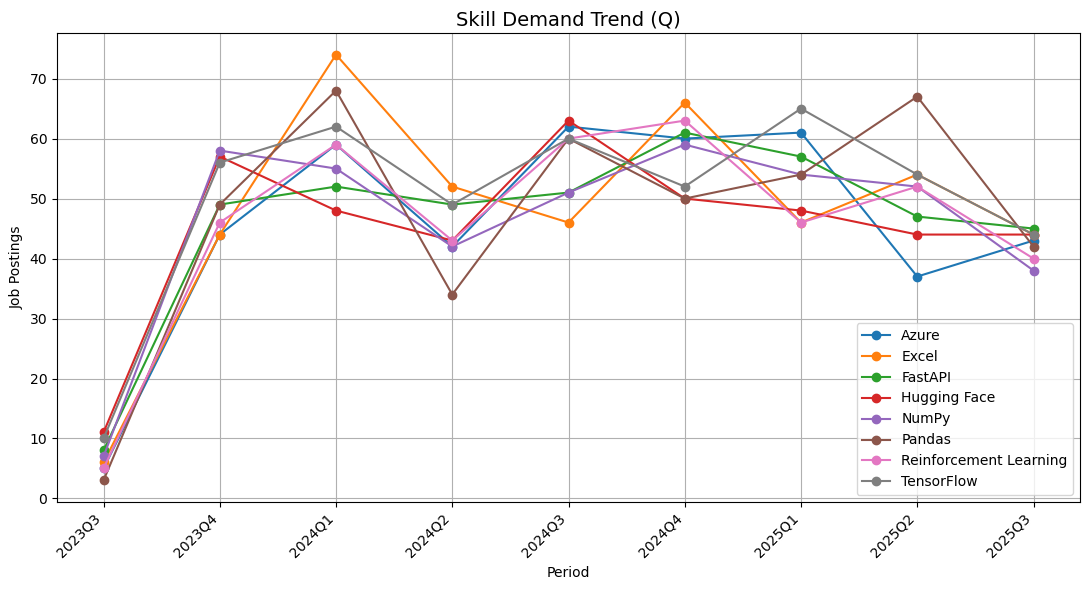

In [16]:
from pathlib import Path

FILE_PATH = "ai_job_market.xlsx"           
SHEET_NAME = "ai_job_market (2)"     
FREQ = "Q"                            
TOP_K_IF_EMPTY = 8                      
EXPORT_CSV = True                         

TARGET_JOB_TITLES = [
  
]
TARGET_SKILLS = [

]

def load_data(file_path: str, sheet_name: str) -> pd.DataFrame:
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    df["posted_date"] = pd.to_datetime(df["posted_date"], errors="coerce")
    df = df.dropna(subset=["posted_date"])
    return df

def to_period_label(s: pd.Series, freq: str) -> pd.Series:
    if freq.upper() == "Q":
        return s.dt.to_period("Q").astype(str)
    elif freq.upper() == "M":
        return s.dt.to_period("M").astype(str)
    else:
        raise ValueError("FREQ 必须是 'M' 或 'Q'")

def aggregate_job_title_trend(df: pd.DataFrame, titles: list | None, freq: str) -> pd.DataFrame:
    if not titles:
        top_titles = df["job_title"].value_counts().head(TOP_K_IF_EMPTY).index.tolist()
    else:
        top_titles = titles

    use = df[df["job_title"].isin(top_titles)].copy()
    use["period"] = to_period_label(use["posted_date"], freq)
    grouped = (
        use.groupby(["period", "job_title"])
           .size()
           .reset_index(name="count")
           .sort_values(["period", "job_title"])
    )
    pivot = grouped.pivot(index="period", columns="job_title", values="count").fillna(0).astype(int)
    pivot = pivot.sort_index()  
    return pivot

def explode_skills_column(df: pd.DataFrame) -> pd.DataFrame:
    skills = (
        df.dropna(subset=["skills_required"])
          .assign(skill=lambda x: x["skills_required"].str.split(","))
          .explode("skill")
    )
    skills["skill"] = skills["skill"].str.strip()
    skills = skills[skills["skill"] != ""]
    return skills

def aggregate_skill_trend(df: pd.DataFrame, skills: list | None, freq: str) -> pd.DataFrame:
    skill_df = explode_skills_column(df)
    if not skills:
        top_skills = skill_df["skill"].value_counts().head(TOP_K_IF_EMPTY).index.tolist()
    else:
        top_skills = skills

    use = skill_df[skill_df["skill"].isin(top_skills)].copy()
    use["period"] = to_period_label(use["posted_date"], freq)
    grouped = (
        use.groupby(["period", "skill"])
           .size()
           .reset_index(name="count")
           .sort_values(["period", "skill"])
    )
    pivot = grouped.pivot(index="period", columns="skill", values="count").fillna(0).astype(int)
    pivot = pivot.sort_index()
    return pivot

def plot_lines(pivot: pd.DataFrame, title: str, xlabel: str = "Period", ylabel: str = "Job Postings"):
    plt.figure(figsize=(11, 6))
    for col in pivot.columns:
        plt.plot(pivot.index, pivot[col], marker="o", label=str(col))
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45, ha="right")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def maybe_export_csv(df: pd.DataFrame, name: str, freq: str):
    if not EXPORT_CSV:
        return
    out = Path(f"{name}_{freq}.csv")
    df.to_csv(out, encoding="utf-8-sig")
    print(f"已导出: {out}")


data = load_data(FILE_PATH, SHEET_NAME)


job_pivot = aggregate_job_title_trend(data, TARGET_JOB_TITLES, FREQ)
print("\n[Job Title Trend]")
print(job_pivot)
maybe_export_csv(job_pivot, "job_title_trend", FREQ)
plot_lines(job_pivot, title=f"Job Title Demand Trend ({FREQ})")


skill_pivot = aggregate_skill_trend(data, TARGET_SKILLS, FREQ)
print("\n[Skill Trend]")
print(skill_pivot)
maybe_export_csv(skill_pivot, "skill_trend", FREQ)
plot_lines(skill_pivot, title=f"Skill Demand Trend ({FREQ})")

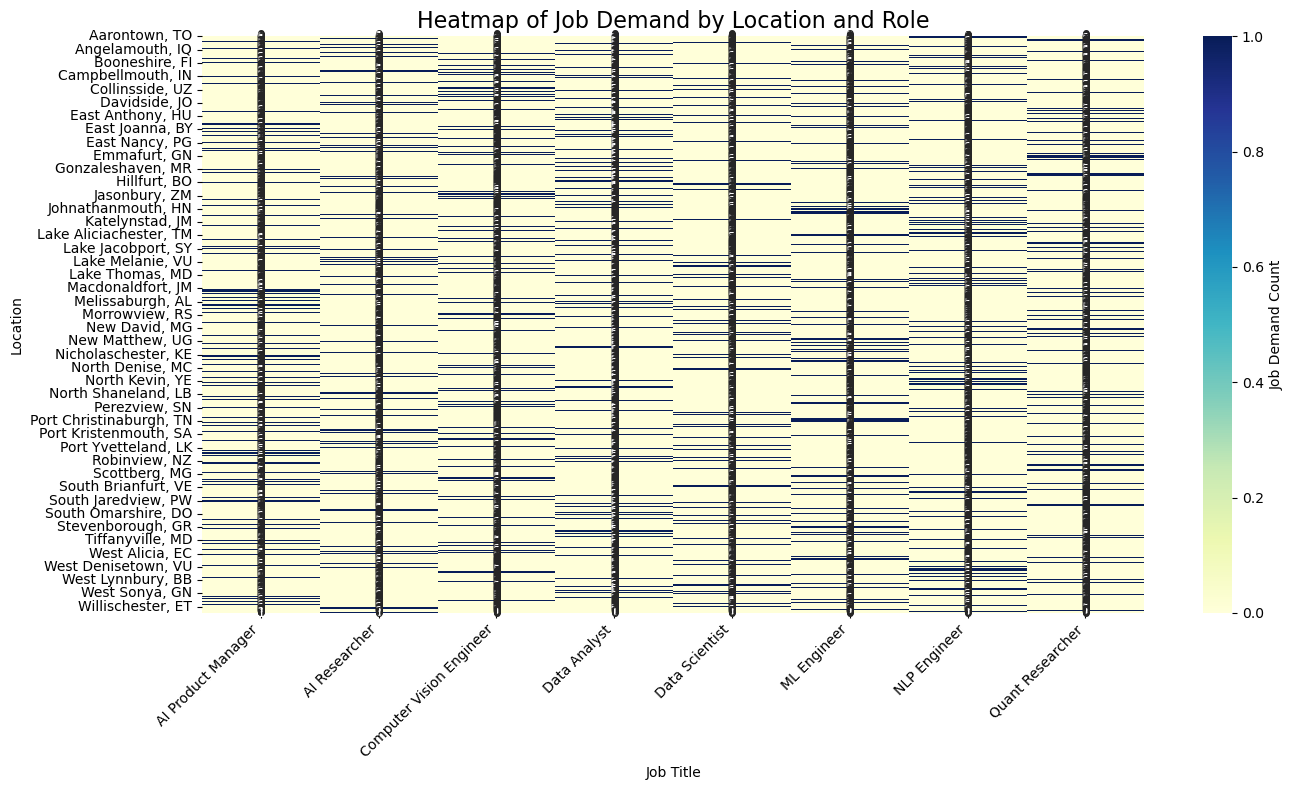

In [9]:
import seaborn as sns

file_path = "ai_job_market.xlsx"  
data = pd.read_excel(file_path, sheet_name="ai_job_market (2)")

data['posted_date'] = pd.to_datetime(data['posted_date'], errors='coerce')

data['location'] = data['location'].astype(str)

heatmap_data = pd.pivot_table(
    data,
    index='location',
    columns='job_title',
    values='job_id',   
    aggfunc='count',
    fill_value=0
)


plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_data,
    cmap="YlGnBu",
    annot=True,
    fmt="d",
    cbar_kws={'label': 'Job Demand Count'}
)
plt.title("Heatmap of Job Demand by Location and Role", fontsize=16)
plt.xlabel("Job Title")
plt.ylabel("Location")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

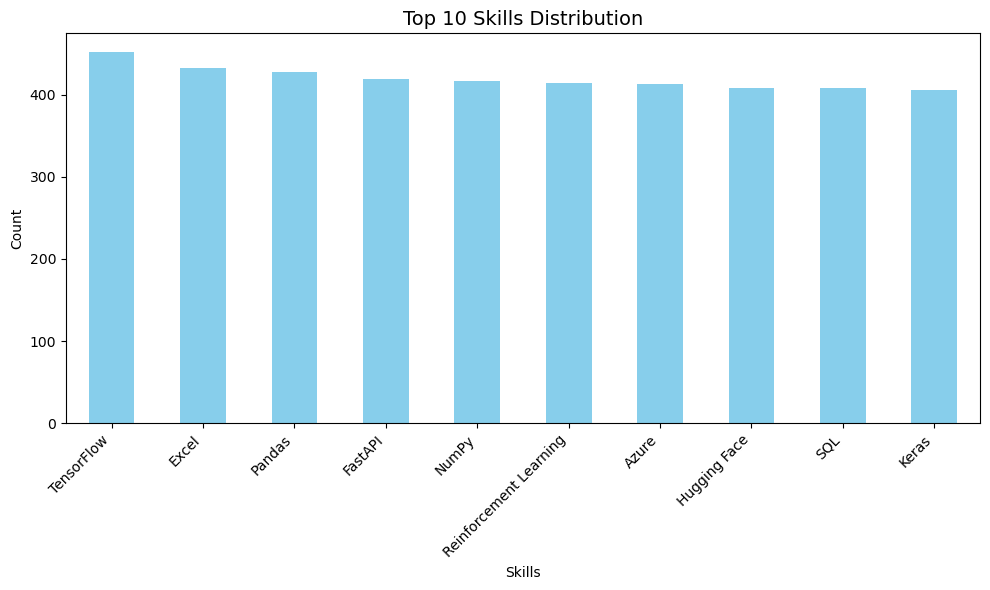

In [10]:
file_path = "ai_job_market.xlsx"
data = pd.read_excel(file_path, sheet_name="ai_job_market (2)")

skills = data['skills_required'].dropna().str.split(',').explode().str.strip()
skill_counts = skills.value_counts().head(10)

plt.figure(figsize=(10,6))
skill_counts.plot(kind="bar", color="skyblue")
plt.title("Top 10 Skills Distribution", fontsize=14)
plt.ylabel("Count")
plt.xlabel("Skills")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

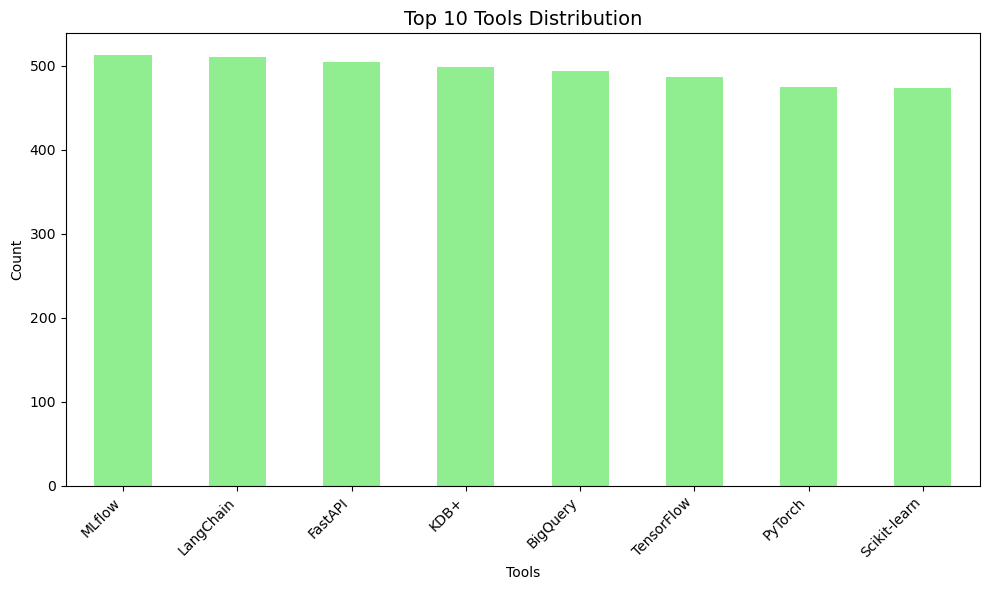

In [11]:
file_path = "ai_job_market.xlsx"
data = pd.read_excel(file_path, sheet_name="ai_job_market (2)")

tools = data['tools_preferred'].dropna().str.split(',').explode().str.strip()
tool_counts = tools.value_counts().head(10)

plt.figure(figsize=(10,6))
tool_counts.plot(kind="bar", color="lightgreen")
plt.title("Top 10 Tools Distribution", fontsize=14)
plt.ylabel("Count")
plt.xlabel("Tools")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

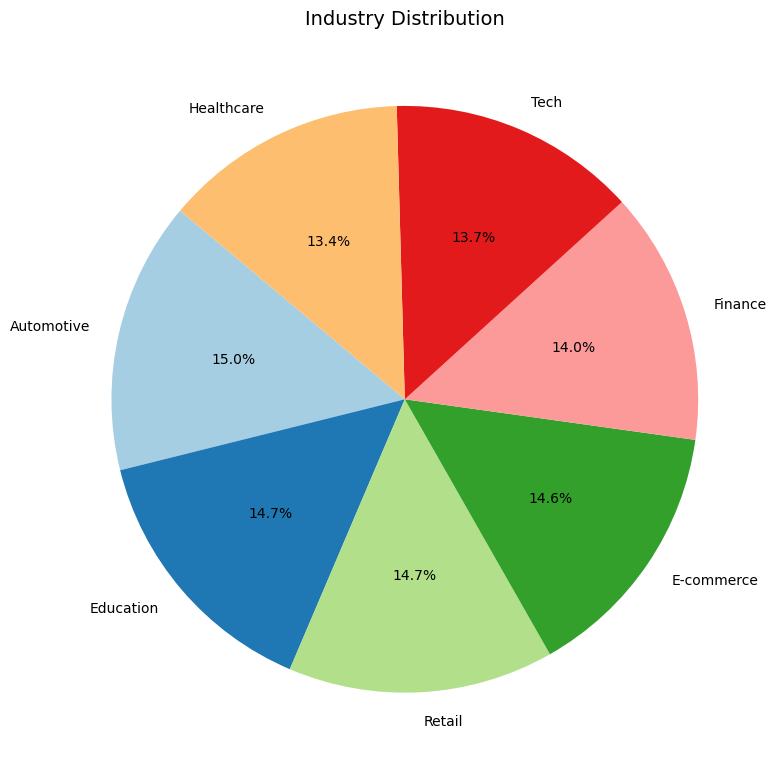

In [12]:
file_path = "ai_job_market.xlsx"
data = pd.read_excel(file_path, sheet_name="ai_job_market (2)")

industry_counts = data['industry'].value_counts().head(8)

plt.figure(figsize=(8,8))
industry_counts.plot(kind="pie", autopct="%1.1f%%", startangle=140, colors=plt.cm.Paired.colors)
plt.title("Industry Distribution", fontsize=14)
plt.ylabel("")
plt.tight_layout()
plt.show()

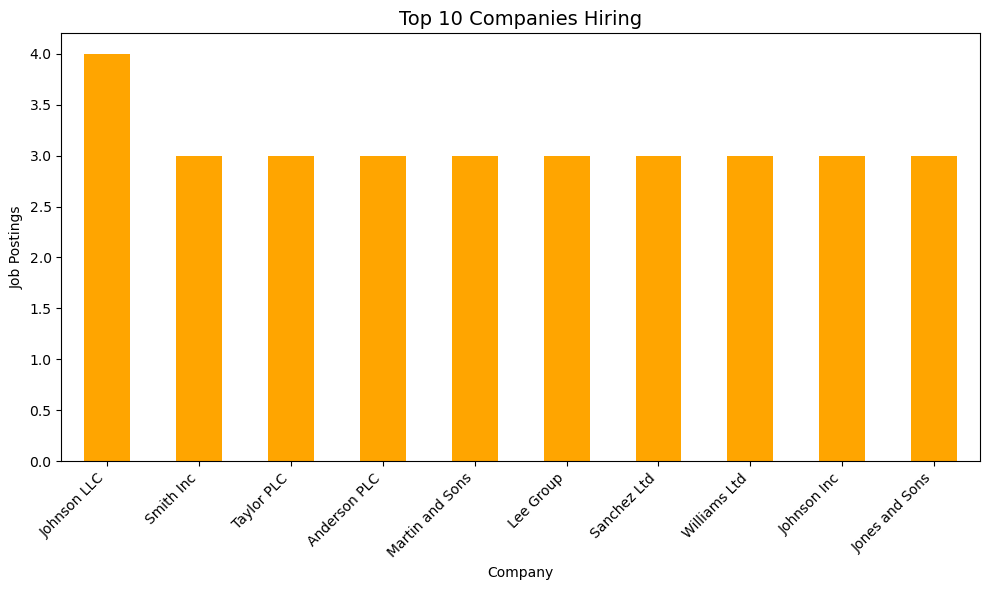

In [13]:
file_path = "ai_job_market.xlsx"
data = pd.read_excel(file_path, sheet_name="ai_job_market (2)")

company_counts = data['company_name'].value_counts().head(10)

plt.figure(figsize=(10,6))
company_counts.plot(kind="bar", color="orange")
plt.title("Top 10 Companies Hiring", fontsize=14)
plt.ylabel("Job Postings")
plt.xlabel("Company")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()